<a href="https://colab.research.google.com/github/ChangHuiLai/Polaris/blob/main/Technical%20analysis_XGBoost_0228.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
#seaborn 基於Matplotlib提供更加美觀的統計繪圖工具
import seaborn as sns
#StandardScaler 用於標準化資料（均值為 0，標準差為 1）
from sklearn.preprocessing import StandardScaler
import datetime as t
from datetime import date
#yf.pdr_override()""
pd.core.common.is_list_like = pd.api.types.is_list_like

import yfinance as yf
print(yf.__version__)
!pip install --upgrade yfinance
#!pip install --upgrade yahooquery

0.2.54


In [ ]:
#Diable the warnings 關閉不必要的警告，讓輸出可以更簡潔
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = yf.download("0050.TW", start="2014-12-01", end="2024-12-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
Date,,,,,
2014-12-01,48.821693,49.296750,48.346631,48.456262,21282946
2014-12-02,48.090824,48.602426,47.981193,48.492796,19739586
2014-12-03,48.858234,48.967865,48.017740,48.090831,11865879
2014-12-04,49.040939,49.296740,49.040939,49.150570,11366115
2014-12-05,48.858234,49.040950,48.785149,49.040950,4318019
...,...,...,...,...,...
2024-11-25,189.727722,192.094997,189.629079,192.045676,7826663
2024-11-26,187.261795,187.705657,186.226107,187.508387,11390822


In [ ]:
# 計算技術指標
df["Diff"] = df["Close"].diff()
df["SMA_2"] = df["Close"].rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]

# 計算 RSI（相對強弱指標）
def compute_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df["RSI"] = compute_RSI(df)

# 計算 MACD（指數移動平均線）
def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()
    long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

df["MACD"], df["MACD_Signal"] = compute_MACD(df)

# 設定預測目標 (y)
df["y"] = df["Close"].shift(-1)  # 預測下一天的收盤價

# 刪除不需要的欄位
df = df.drop(["Open", "High", "Low", "Volume", "Diff"], axis=1).dropna()
# 顯示前後幾筆數據
print(df.head())
print(df.tail())

Price           Close      SMA_2   Force_Index        RSI      MACD  \
Ticker        0050.TW                                                 
Date                                                                  
2014-12-18  46.556011  46.501196  4.000810e+08  24.590081 -0.499792   
2014-12-19  47.652298  47.104155  8.192673e+08  39.473536 -0.458767   
2014-12-22  48.237000  47.944649  3.590742e+08  51.351378 -0.374754   
2014-12-23  48.090824  48.163912  2.520924e+08  41.984681 -0.316321   
2014-12-24  48.456257  48.273540  3.371310e+08  44.117735 -0.237785   

Price      MACD_Signal          y  
Ticker                             
Date                               
2014-12-18   -0.282578  47.652298  
2014-12-19   -0.317815  48.237000  
2014-12-22   -0.329203  48.090824  
2014-12-23   -0.326627  48.456257  
2014-12-24   -0.308858  48.456257  
Price            Close       SMA_2   Force_Index        RSI      MACD  \
Ticker         0050.TW                                                

In [ ]:
# 將處理後的 DataFrame 存入 CSV
df.to_csv("0050_with_indicators_fixed.csv")
print("數據已儲存為 0050_with_indicators_fixed.csv")

數據已儲存為 0050_with_indicators_fixed.csv


In [ ]:
"""
from yahooquery import Ticker
import pandas as pd
import pytz  # 用來轉換時區

# 使用 yahooquery 抓取 0050.TW 的歷史數據
ticker = Ticker("0050.TW")
df = ticker.history(period="max")

# 重設索引，方便儲存
df = df.reset_index()

# 選擇需要的欄位
df = df[['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume']]

# 轉換日期格式
df['date'] = pd.to_datetime(df['date'], utc=True)  # 確保是 UTC 時間
df['date'] = df['date'].dt.tz_convert('Asia/Taipei')  # 轉換為台灣時間 (UTC+8)

# 過濾時間區間 2008/12/31 ~ 2024/12/31
start_date = pd.Timestamp("2008-12-31", tz="Asia/Taipei")
end_date = pd.Timestamp("2024-12-31", tz="Asia/Taipei")
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

SyntaxError: incomplete input (<ipython-input-8-b18818966ca8>, line 1)

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
# shape
# 顯示資料集的維度 (rows, columns)
df.shape #shape主要是用來檢查資料行數和欄數，幫助快速了解資料規模

(2426, 7)

## 1-2. 技術指標計算

In [ ]:
"""
# 計算移動平均線 (MA)
for period in [5, 10, 20, 60, 120, 240]:
    df[f'MA_{period}'] = df['close'].rolling(window=period, min_periods=1).mean()

# 計算 RSI (相對強弱指數)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss.replace(0, 1e-10)  # 避免除以零
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['close'], 14)

# 計算 9 日 KD 指標 (%K, %D)
low_min = df['low'].rolling(window=9, min_periods=1).min()
high_max = df['high'].rolling(window=9, min_periods=1).max()
df['%K'] = ((df['close'] - low_min) * 100 / (high_max - low_min)).replace([float('inf'), -float('inf')], 50)
df['%D'] = df['%K'].rolling(window=3, min_periods=1).mean()

# 計算 MACD
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
#df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 計算額外技術指標
df['Return'] = df['close'].pct_change().fillna(0)  # 日漲跌幅
df['Bias'] = ((df['close'] - df['MA_20']) / df['MA_20']).fillna(0)  # 乖離率
#df['Volume_Change'] = df['volume'].pct_change().fillna(0)  # 成交量變化率


# 存成 CSV
df.to_csv('0050_with_indicators_fixed.csv', index=False, encoding="utf-8-sig")

# 顯示前後幾筆數據
print(df.head())
print(df.tail())
"""

MACD = 12 天指數移動平均線（EMA） - 26 天指數移動平均線（EMA）
表示短期趨勢與長期趨勢的差異，當 MACD 正數時，代表短期趨勢比長期趨勢強勢；反之則是弱勢。
Signal Line = MACD 的 9 天指數移動平均線（EMA）
目的：平滑 MACD 值，減少雜訊，讓交易訊號更明確。

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import xgboost
print(xgboost.__version__)

2.1.4


In [ ]:
"""
# 讀取儲存的 CSV 檔案
df = pd.read_csv("0050_with_indicators_fixed.csv", parse_dates=["Date"])

# 設定索引為日期
df.set_index("Date", inplace=True)

# 顯示前幾筆數據確認讀取是否正確
print(df.head())


# 新增波動性與成交量特徵
#df['ATR'] = df['high'] - df['low']  # 均幅指標
#df['Volume_Change'] = df['volume'].pct_change().fillna(0)
#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day_of_week'] = df.index.dayofweek

# 新增時間序列特徵
df['ATR'] = df['high'] - df['low']  # 均幅指標
df['Volume_Change'] = df['volume'].pct_change().fillna(0)
df['close_lag_1'] = df['close'].shift(1)  # 滯後1天
df['close_lag_2'] = df['close'].shift(2)  # 滯後2天
df['rolling_mean_5'] = df['close'].rolling(window=5).mean()  # 5日均線
df['rolling_mean_10'] = df['close'].rolling(window=10).mean()  # 10日均線
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['quarter'] = df.index.quarter

# 選擇關鍵特徵與目標變數
target = "close"
features = ["open", "high", "low", "volume", "MA_20", "MACD", "RSI_14", "ATR", "Volume_Change", "close_lag_1", "close_lag_2", "rolling_mean_5", "rolling_mean_10", "year", "month", "day_of_week", "day_of_month", "quarter"]

# 選擇特徵與目標變數
#target = "close"
#features = ["open", "high", "low", "volume", "MA_5", "MA_10", "MA_20", "MA_60", "MA_120", "MA_240", "RSI_14", "%K", "%D", "MACD", "Signal_Line", "Return", "Bias", "ATR", "Volatility", "Volume_Change", "year", "month", "day_of_week"]

# 選擇關鍵特徵與目標變數 可用
#target = "close"
#features = ["open", "high", "low", "volume", "MA_5", "MA_10", "MA_20", "MA_60", "%K", "%D", "MACD", "RSI_14", "ATR", "Bias", "Volume_Change", "year", "month", "day_of_week"]

# 選擇關鍵特徵與目標變數
#target = "close"
#features = ["open", "high", "low", "volume", "MA_20", "MACD", "RSI_14", "ATR", "Volume_Change", "year", "month", "day_of_week"]

# 選擇特徵與目標變數
#target = "close"  # 預測收盤價
#features = ["open", "high", "low", "volume", "MA_5", "MA_10", "MA_20", "MA_60", "MA_120", "MA_240", "RSI_14", "%K", "%D", "MACD", "Signal_Line", "Return", "Bias"]

# 移除 NaN 和無效數據
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 確保無 NaN 值
#df.dropna(inplace=True)

# 設定時間範圍進行資料分割
#train_df = df[(df.index >= "2014-12-01") & (df.index < "2022-01-01")]
#test_df = df[(df.index >= "2023-01-01")]
"""

In [ ]:
# 劃分訓練集與測試集 (前90% 為訓練集，最後10% 為測試集)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df.drop("y", axis=1).values
y_train = train_df["y"].values
X_test = test_df.drop("y", axis=1).values
y_test = test_df["y"].values

In [ ]:
# 分割特徵與標籤
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# 轉換成 XGBoost 格式
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)

NameError: name 'features' is not defined

In [ ]:
# 確保數據無異常值
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [ ]:
"""
# 超參數調整
grid_params = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [200, 500],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'reg_lambda': [10, 100],
    'reg_alpha': [1, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror"),
    param_grid=grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
"""

'\n# 超參數調整\ngrid_params = {\n    \'max_depth\': [3, 4],\n    \'learning_rate\': [0.01, 0.05],\n    \'n_estimators\': [200, 500],\n    \'subsample\': [0.5, 0.7],\n    \'colsample_bytree\': [0.5, 0.7],\n    \'reg_lambda\': [10, 100],\n    \'reg_alpha\': [1, 10]\n}\n\ngrid_search = GridSearchCV(\n    estimator=xgb.XGBRegressor(objective="reg:squarederror"),\n    param_grid=grid_params,\n    cv=5,\n    scoring="neg_mean_squared_error",\n    verbose=2\n)\n\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

In [ ]:
"""
# 超參數調整
grid_params = {
    'max_depth': [2, 3],  # 降低樹深度
    'learning_rate': [0.005, 0.01],  # 減少學習率
    'n_estimators': [500, 1000],  # 增加樹的數量
    'subsample': [0.5, 0.6],  # 控制每棵樹的訓練數據比例
    'colsample_bytree': [0.5, 0.6],  # 控制每棵樹使用的特徵比例
    'reg_lambda': [100, 500],  # L2 正則化
    'reg_alpha': [10, 50],  # L1 正則化
    'min_child_weight': [5, 10]  # 避免小樣本過度擬合
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror"),
    param_grid=grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
"""

'\n# 超參數調整\ngrid_params = {\n    \'max_depth\': [2, 3],  # 降低樹深度\n    \'learning_rate\': [0.005, 0.01],  # 減少學習率\n    \'n_estimators\': [500, 1000],  # 增加樹的數量\n    \'subsample\': [0.5, 0.6],  # 控制每棵樹的訓練數據比例\n    \'colsample_bytree\': [0.5, 0.6],  # 控制每棵樹使用的特徵比例\n    \'reg_lambda\': [100, 500],  # L2 正則化\n    \'reg_alpha\': [10, 50],  # L1 正則化\n    \'min_child_weight\': [5, 10]  # 避免小樣本過度擬合\n}\n\ngrid_search = GridSearchCV(\n    estimator=xgb.XGBRegressor(objective="reg:squarederror"),\n    param_grid=grid_params,\n    cv=5,\n    scoring="neg_mean_squared_error",\n    verbose=2\n)\n\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

In [ ]:
"""
# 超參數調整 6:45
grid_params = {
    'max_depth': [3, 4],  # 增加深度
    'learning_rate':[0.005, 0.01],# [0.01, 0.02],  # 提高學習率
    'n_estimators': [800, 1200],  # 增加樹的數量
    'subsample': [0.8, 0.9],#[0.8],  # 提高樣本比例
    'colsample_bytree': [0.8, 0.9],#[0.8],  # 提高特徵比例
    'reg_lambda': [10, 50],  # 降低 L2 正則化
    'reg_alpha': [1, 5],  # 降低 L1 正則化
    'min_child_weight': [1, 5]  # 增加最小權重
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror"),
    param_grid=grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
"""

'\n# 超參數調整 6:45\ngrid_params = {\n    \'max_depth\': [3, 4],  # 增加深度\n    \'learning_rate\':[0.005, 0.01],# [0.01, 0.02],  # 提高學習率\n    \'n_estimators\': [800, 1200],  # 增加樹的數量\n    \'subsample\': [0.8, 0.9],#[0.8],  # 提高樣本比例\n    \'colsample_bytree\': [0.8, 0.9],#[0.8],  # 提高特徵比例\n    \'reg_lambda\': [10, 50],  # 降低 L2 正則化\n    \'reg_alpha\': [1, 5],  # 降低 L1 正則化\n    \'min_child_weight\': [1, 5]  # 增加最小權重\n}\n\ngrid_search = GridSearchCV(\n    estimator=xgb.XGBRegressor(objective="reg:squarederror"),\n    param_grid=grid_params,\n    cv=5,\n    scoring="neg_mean_squared_error",\n    verbose=2\n)\n\ngrid_search.fit(X_train, y_train)\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

In [ ]:
# 超參數調整
grid_params = {
    'max_depth': [3, 4],  # 降低過擬合風險
    'learning_rate': [0.005, 0.01],  # 控制學習率
    'n_estimators': [800, 1000],  # 增加樹的數量
    'subsample': [0.7, 0.8],  # 增加隨機抽樣
    'colsample_bytree': [0.7, 0.8],  # 提高特徵利用率
    'reg_lambda': [10, 50],  # 增強 L2 正則化
    'reg_alpha': [1, 5],  # 增強 L1 正則化
    'min_child_weight': [5, 10]  # 限制小樣本，避免過擬合
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror"),
    param_grid=grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alpha=1, reg_lambda=10, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alpha=1, reg_lambda=10, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alpha=1, reg_lambda=10, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alpha=1, reg_lambda=10, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alpha=1, reg_lambda=10, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=800, reg_alph

In [ ]:
"""
# 超參數調整
grid_params = {
    'max_depth': [2, 3],  # 降低樹深度，避免過擬合
    'learning_rate': [0.01, 0.02],  # 控制學習率
    'n_estimators': [400, 1200],  # 減少樹的數量，降低過擬合風險
    'subsample': [0.6],  # 減少過擬合
    'colsample_bytree': [0.6],  # 減少特徵冗餘
    'reg_lambda': [50, 100],  # 增強 L2 正則化
    'reg_alpha': [5, 10],  # 增強 L1 正則化
    'min_child_weight': [10, 20]  # 限制小樣本，避免過擬合
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror"),
    param_grid=grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=2
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
"""

In [ ]:
"""2
# 訓練最佳模型
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    **best_params
}

# 轉換為 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 訓練模型
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1200,  # 減少樹數
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=100,  # 降低早停輪數
    verbose_eval=50
)
"""

In [ ]:
"""1
# 訓練最佳模型
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    **best_params
}

# 轉換為 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 訓練模型
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,  # 增加樹數
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=150,  # 提高 early stopping 避免過擬合
    verbose_eval=50
)
"""

In [ ]:
# 訓練最佳模型
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    **best_params
}

# 轉換為 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 訓練模型
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,  # 減少樹數，降低過擬合風險
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=500,  # 允許更多學習機會
    verbose_eval=50
)

[0]	train-rmse:27.97775	test-rmse:84.89192
[50]	train-rmse:17.59356	test-rmse:69.73212
[100]	train-rmse:11.05817	test-rmse:59.85300
[150]	train-rmse:7.19203	test-rmse:53.62504
[200]	train-rmse:4.68862	test-rmse:49.03850
[250]	train-rmse:3.12093	test-rmse:45.87274
[300]	train-rmse:2.22041	test-rmse:43.69493
[350]	train-rmse:1.65643	test-rmse:42.02864
[400]	train-rmse:1.32818	test-rmse:40.83360
[450]	train-rmse:1.14642	test-rmse:39.98554
[500]	train-rmse:1.04672	test-rmse:39.37756
[550]	train-rmse:0.99048	test-rmse:38.94958
[600]	train-rmse:0.95662	test-rmse:38.67554
[650]	train-rmse:0.93393	test-rmse:38.45037
[700]	train-rmse:0.91821	test-rmse:38.30186
[750]	train-rmse:0.90676	test-rmse:38.16538
[800]	train-rmse:0.89713	test-rmse:38.06985
[850]	train-rmse:0.88954	test-rmse:37.96529
[900]	train-rmse:0.88351	test-rmse:37.87520
[950]	train-rmse:0.87721	test-rmse:37.84386
[1000]	train-rmse:0.87123	test-rmse:37.81470
[1050]	train-rmse:0.86610	test-rmse:37.76871
[1100]	train-rmse:0.86148	test

In [ ]:
# 進行預測
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dtest)

In [ ]:
# 評估模型
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

Train RMSE: 0.7929, Test RMSE: 37.6556
Train MAE: 0.5666, Test MAE: 31.2384
Train R2: 0.9992, Test R2: -1.7767


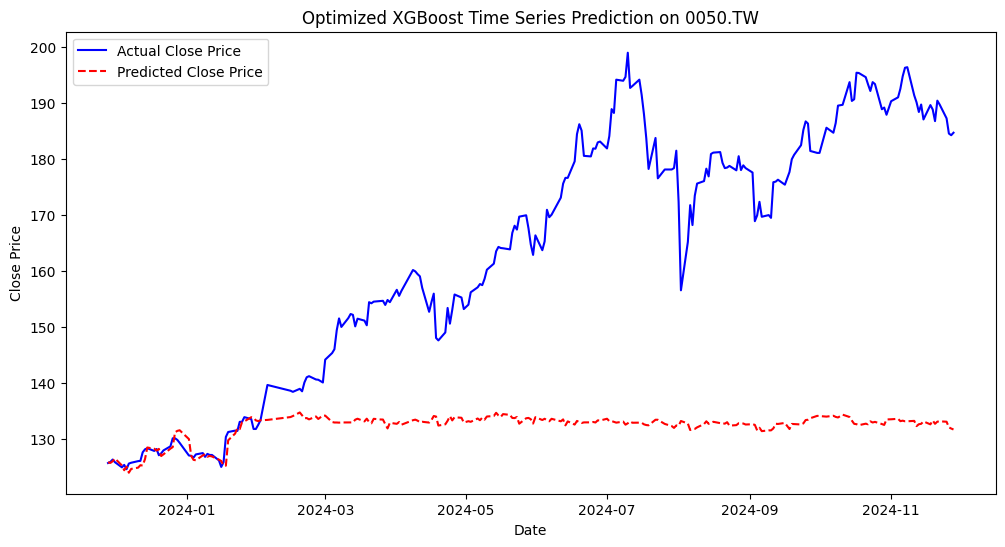

In [ ]:
# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label="Actual Close Price", color="blue")
plt.plot(test_df.index, y_pred_test, label="Predicted Close Price", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Optimized XGBoost Time Series Prediction on 0050.TW")
plt.legend()
plt.show()

In [ ]:
"""
# 設定 XGBoost 參數
params = {
    "objective": "reg:squarederror",  # 均方誤差
    "eval_metric": "rmse",  # 根均方誤差
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 1000
}
"""

[*********************100%***********************]  1 of 1 completed


Train Accuracy: 0.9863, Test Accuracy: 0.4733
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.83      0.58       109
           1       0.57      0.19      0.28       134

    accuracy                           0.47       243
   macro avg       0.51      0.51      0.43       243
weighted avg       0.52      0.47      0.42       243



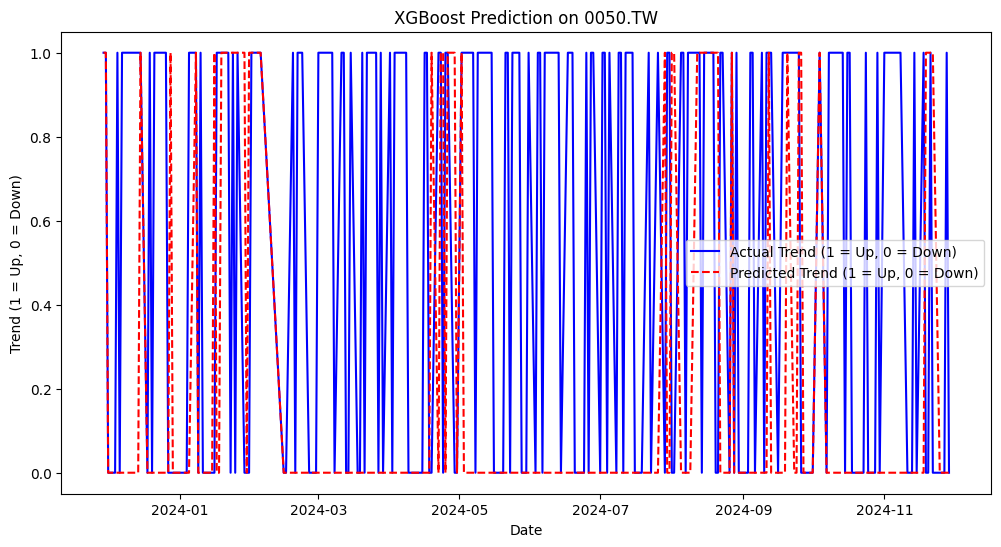

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 下載 0050.TW 股票數據
df = yf.download("0050.TW", start="2014-12-01", end="2024-12-01")

# 計算技術指標
df["Diff"] = df["Close"].diff()
df["SMA_2"] = df["Close"].rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]

# 計算 RSI
def compute_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df["RSI"] = compute_RSI(df)

# 計算 MACD
def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()
    long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

df["MACD"], df["MACD_Signal"] = compute_MACD(df)

# 設定預測目標 (y_class) - 預測明天是上漲 (1) 或 下跌 (0)
df["y_class"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# 刪除不需要的欄位
df = df.drop(["Open", "High", "Low", "Volume", "Diff"], axis=1).dropna()

# 劃分訓練集與測試集 (前90% 為訓練集，最後10% 為測試集)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 重新定義 X, y
X_train = train_df.drop("y_class", axis=1).values
y_train = train_df["y_class"].values
X_test = test_df.drop("y_class", axis=1).values
y_test = test_df["y_class"].values

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 預測
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# 計算準確率
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# 顯示分類報告
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label="Actual Trend (1 = Up, 0 = Down)", color="blue", linestyle="-")
plt.plot(test_df.index, y_pred_test, label="Predicted Trend (1 = Up, 0 = Down)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Trend (1 = Up, 0 = Down)")
plt.title("XGBoost Prediction on 0050.TW")
plt.legend()
plt.show()

In [ ]:
n_estimators=500：相當於訓練 500 棵決策樹，這有點類似 Epoch。
subsample=0.8：類似於批次訓練的概念，這表示每次訓練時僅隨機取 80% 的數據來訓練每棵樹。

[*********************100%***********************]  1 of 1 completed


Train Accuracy: 0.9872, Test Accuracy: 0.4774
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.80      0.58       109
           1       0.57      0.22      0.31       134

    accuracy                           0.48       243
   macro avg       0.51      0.51      0.45       243
weighted avg       0.52      0.48      0.43       243



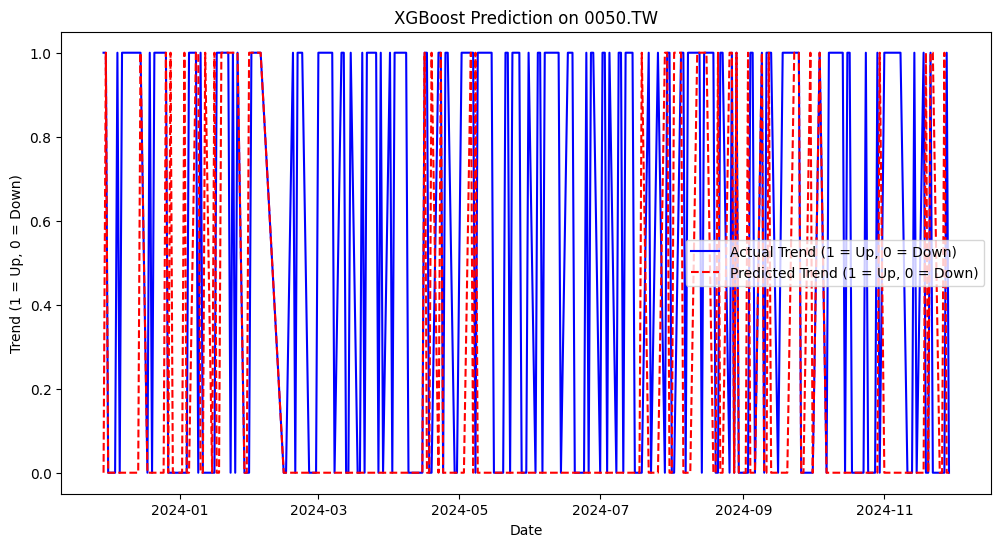

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 下載 0050.TW 股票數據
df = yf.download("0050.TW", start="2014-12-01", end="2024-12-01")

# 計算技術指標
df["Diff"] = df["Close"].diff()
df["SMA_2"] = df["Close"].rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]

# 計算 RSI
def compute_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df["RSI"] = compute_RSI(df)

# 計算 MACD（僅保留 MACD，不使用 MACD_Signal）
def compute_MACD(data, short_window=12, long_window=26):
    short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()
    long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    return macd

df["MACD"] = compute_MACD(df)

# 計算 Williams %R
def compute_williams_r(data, window=14):
    highest_high = data["High"].rolling(window=window).max()
    lowest_low = data["Low"].rolling(window=window).min()
    williams_r = -100 * ((highest_high - data["Close"]) / (highest_high - lowest_low))
    return williams_r

df["Williams_R"] = compute_williams_r(df)

# 設定預測目標 (y_class) - 預測明天是上漲 (1) 或 下跌 (0)
df["y_class"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# 刪除不需要的欄位
df = df.drop(["Open", "High", "Low", "Volume", "Diff"], axis=1).dropna()

# 劃分訓練集與測試集 (前90% 為訓練集，最後10% 為測試集)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 重新定義 X, y
X_train = train_df.drop("y_class", axis=1).values
y_train = train_df["y_class"].values
X_test = test_df.drop("y_class", axis=1).values
y_test = test_df["y_class"].values

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用 SMOTE 處理不平衡數據
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# 預測
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# 計算準確率
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# 顯示分類報告
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label="Actual Trend (1 = Up, 0 = Down)", color="blue", linestyle="-")
plt.plot(test_df.index, y_pred_test, label="Predicted Trend (1 = Up, 0 = Down)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Trend (1 = Up, 0 = Down)")
plt.title("XGBoost Prediction on 0050.TW")
plt.legend()
plt.show()

In [ ]:
!pip install --upgrade xgboost

[*********************100%***********************]  1 of 1 completed

[0]	test-logloss:0.69669
[1]	test-logloss:0.69661
[2]	test-logloss:0.69876
[3]	test-logloss:0.70070
[4]	test-logloss:0.70193
[5]	test-logloss:0.70398
[6]	test-logloss:0.70194
[7]	test-logloss:0.70413
[8]	test-logloss:0.70537
[9]	test-logloss:0.70779
[10]	test-logloss:0.70993
[11]	test-logloss:0.71101
[12]	test-logloss:0.71217
[13]	test-logloss:0.71322
[14]	test-logloss:0.71379
[15]	test-logloss:0.71864
[16]	test-logloss:0.71987
[17]	test-logloss:0.72072
[18]	test-logloss:0.71992
[19]	test-logloss:0.72178
[20]	test-logloss:0.72192
[21]	test-logloss:0.72369
[22]	test-logloss:0.72320
[23]	test-logloss:0.72295
[24]	test-logloss:0.72579
[25]	test-logloss:0.72761
[26]	test-logloss:0.72777
[27]	test-logloss:0.72698
[28]	test-logloss:0.72682
[29]	test-logloss:0.72719
[30]	test-logloss:0.72765
[31]	test-logloss:0.72667
[32]	test-logloss:0.72719
[33]	test-logloss:0.72695
[34]	test-logloss:0.72715
[35]	test-logloss:0.72723
[36]	test-logloss:0.72817
[37]	test-logloss:0.72816
[38]	test-logloss:0.72

[60]	test-logloss:0.73644
Train Accuracy: 0.6479, Test Accuracy: 0.5041
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.87      0.61       110
           1       0.66      0.20      0.31       134

    accuracy                           0.50       244
   macro avg       0.57      0.54      0.46       244
weighted avg       0.57      0.50      0.45       244



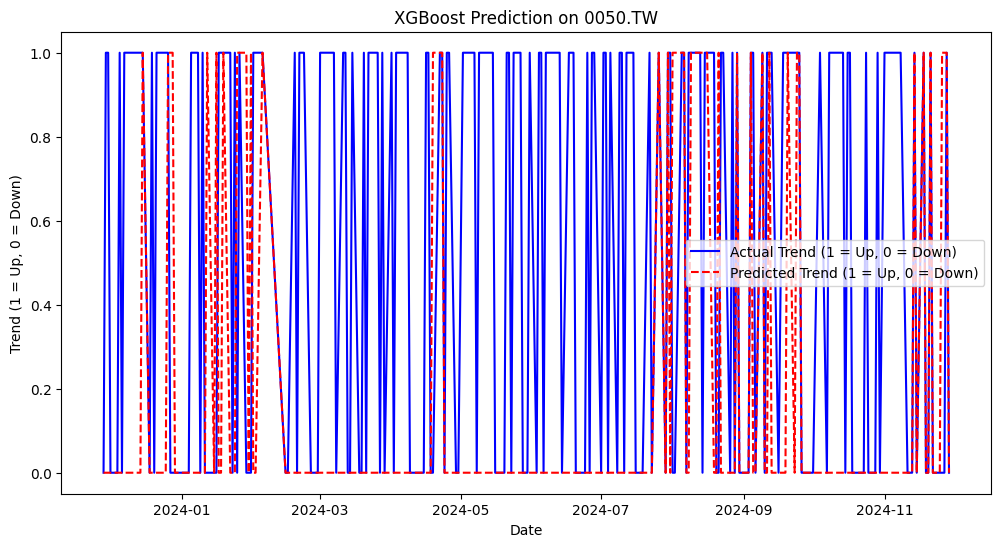

'\n# 繪製預測結果\nplt.figure(figsize=(12, 6))\nplt.plot(test_df.index, test_df["Close"], label="Actual Close Price", color="blue", alpha=0.6)\nplt.scatter(test_df.index, test_df["Close"], c=y_pred_test, cmap="coolwarm", label="Predicted Trend (Red = Down, Blue = Up)")\nplt.xlabel("Date")\nplt.ylabel("Close Price")\nplt.title("XGBoost Stock Price Trend Prediction for 0050.TW")\nplt.legend()\nplt.show()\n'

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 下載 0050.TW 股票數據
df = yf.download("0050.TW", start="2014-12-01", end="2024-12-01")

# 計算技術指標
df["Diff"] = df["Close"].diff()
df["SMA_2"] = df["Close"].rolling(2, min_periods=1).mean()
df["Force_Index"] = np.log1p(df["Close"] * df["Volume"])

# 計算 RSI
def compute_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df["RSI"] = compute_RSI(df)

# 計算 MACD
def compute_MACD(data, short_window=12, long_window=26):
    short_ema = data["Close"].ewm(span=short_window, adjust=False).mean()
    long_ema = data["Close"].ewm(span=long_window, adjust=False).mean()
    return short_ema - long_ema

df["MACD"] = compute_MACD(df)

# 計算 Williams %R
def compute_williams_r(data, window=14):
    highest_high = data["High"].rolling(window=window, min_periods=1).max()
    lowest_low = data["Low"].rolling(window=window, min_periods=1).min()
    return -100 * ((highest_high - data["Close"]) / (highest_high - lowest_low))

df["Williams_R"] = compute_williams_r(df)

# 設定預測目標 (y_class)
df["y_class"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# 刪除不必要的欄位
df = df.drop(["Open", "High", "Low", "Volume", "Diff"], axis=1).dropna()

# 劃分訓練集與測試集 (90% 訓練，10% 測試)
split_idx = int(len(df) * 0.9)
train_df, test_df = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

# 重新定義 X, y
X_train = train_df.drop("y_class", axis=1).values
y_train = train_df["y_class"].values
X_test = test_df.drop("y_class", axis=1).values
y_test = test_df["y_class"].values

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用 SMOTE 處理不平衡數據
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 轉換為 XGBoost DMatrix 格式
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# 設置 XGBoost 參數
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.05,
    "max_depth": 3,#6
    "subsample": 0.8,
    "scale_pos_weight": sum(y_train == 0) / sum(y_train == 1),  # 平衡類別
    "eval_metric": "logloss",
    "random_state": 42
}

# 訓練模型並使用 early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtest, "test")],
    early_stopping_rounds=60,
    verbose_eval=True
)

# 預測
y_pred_train = (xgb_model.predict(dtrain) > 0.5).astype(int)
y_pred_test = (xgb_model.predict(dtest) > 0.5).astype(int)

# 計算準確率
train_acc = accuracy_score(y_train_resampled, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# 顯示分類報告
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label="Actual Trend (1 = Up, 0 = Down)", color="blue", linestyle="-")
plt.plot(test_df.index, y_pred_test, label="Predicted Trend (1 = Up, 0 = Down)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Trend (1 = Up, 0 = Down)")
plt.title("XGBoost Prediction on 0050.TW")
plt.legend()
plt.show()
"""
# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df["Close"], label="Actual Close Price", color="blue", alpha=0.6)
plt.scatter(test_df.index, test_df["Close"], c=y_pred_test, cmap="coolwarm", label="Predicted Trend (Red = Down, Blue = Up)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("XGBoost Stock Price Trend Prediction for 0050.TW")
plt.legend()
plt.show()
"""